# Make dataset

In [30]:
# Autorelaod
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import igraph as ig
import leidenalg
from scipy.special import softmax
import re
from statsmodels.stats.multitest import multipletests
import ast

os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf

config_file="/home/gdallagl/myworkdir/ESMSec/config/config.yaml"
config = mf.load_config(config_file)

mf.set_all_seeds(config["random_seed"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
Seeds set successfully to 42 for random, numpy, and PyTorch (if used).


# Load Uniprot proteins

In [67]:
proteome_uniprot = pd.read_csv(config["data_paths"]["human_proteome_uniprot"])

# Define proteins to use in the follwing analasys
ALLOWED_PROTEINS = set(proteome_uniprot.Entry)
print("Number allowed proteins: ", len(ALLOWED_PROTEINS))
print(*list(ALLOWED_PROTEINS)[:10], "...")

Number allowed proteins:  20210
Q12866 Q9P299 Q9UGK8 Q9UL41 Q5EBM4 Q629K1 Q9UHB6 Q2LD37 Q68CL5 Q6UY01 ...


# Load definitive positive genes

In [28]:
#positive_genes_path = config["data_paths"]["final_positive_genes"]

positive_genes_path = "/home/gdallagl/myworkdir/ESMSec/data/cell_location/secreted_Uniprot-locations_02_positive_proteins.csv"
positive_genes_df = pd.read_csv(positive_genes_path)
display(positive_genes_df)

# Save dataset name for later
dataset_name = "_".join(positive_genes_path.split("/")[-1].split("_")[:2])
print(dataset_name)

# List of geenes
positive_genes = set(positive_genes_df[positive_genes_df.definitive_positive == True].gene)
ambiguos_genes = set(positive_genes_df[positive_genes_df.definitive_positive == False].gene)
print("Number positive genes", len(positive_genes))
print("Number ambiguos genes", len(ambiguos_genes))

,gene,geneset_count,definitive_positive
0,MT-RNR1,1,1
1,CD300H,1,1
2,IGLC7,1,1
3,ODAM,1,1
4,PXDNL,1,1
...,...,...,...
2122,MTRNR2L13,1,1
2123,MTRNR2L11,1,1
2124,SCPPPQ1,1,1
2125,RBAKDN,1,1


secreted_Uniprot-locations
Number positive genes 2126
Number ambiguos genes 0


# Mapping positive_gene --> number genesets

For sampling prob later

In [3]:
tmp = positive_genes_df[positive_genes_df["definitive_positive"] == True]

positive_gene_freq_map = dict(zip(tmp["gene"], tmp["geneset_count"]))
positive_gene_freq_map

{'MT-RNR1': 1,
 'CD300H': 1,
 'IGLC7': 1,
 'ODAM': 1,
 'PXDNL': 1,
 'SSC5D': 1,
 'SSPOP': 1,
 'LAMB4': 1,
 'PRSS37': 1,
 'CLEC18A': 1,
 'LILRA5': 1,
 'COL6A6': 1,
 'A2ML1': 1,
 'CLCA1': 1,
 'COL6A5': 1,
 'VWC2L': 1,
 'IFNL4': 1,
 'CCL24': 1,
 'LGALS9': 1,
 'MASP2': 1,
 'AGRP': 1,
 'PGRMC1': 1,
 'LEFTY2': 1,
 'TULP1': 1,
 'TNFRSF11B': 1,
 'MATN2': 1,
 'QSOX1': 1,
 'AGRN': 1,
 'CHL1': 1,
 'SDCBP': 1,
 'RNASET2': 1,
 'CCL21': 1,
 'FCN1': 1,
 'CCN1': 1,
 'CCL22': 1,
 'WNT10B': 1,
 'WNT7A': 1,
 'NRG2': 1,
 'ADGRB1': 1,
 'HSPB6': 1,
 'NCAN': 1,
 'CXCL11': 1,
 'ENPP3': 1,
 'NRP1': 1,
 'TNFSF11': 1,
 'APOL1': 1,
 'MSTN': 1,
 'WNT9A': 1,
 'WNT9B': 1,
 'EREG': 1,
 'LECT2': 1,
 'PDZD2': 1,
 'SEMA3E': 1,
 'ADAMTS3': 1,
 'ANGPT2': 1,
 'NPFF': 1,
 'PGRMC2': 1,
 'EPHB6': 1,
 'ADAMDEC1': 1,
 'LAMA5': 1,
 'MATN3': 1,
 'VGF': 1,
 'DEFB4A': 1,
 'DEFB4B': 1,
 'TMPRSS2': 1,
 'CCL25': 1,
 'CCL16': 1,
 'PLA2G10': 1,
 'FGF10': 1,
 'RS1': 1,
 'FLRT2': 1,
 'PLXNB1': 1,
 'ADAM12': 1,
 'KLK10': 1,
 'SPINT1': 1,
 

In [5]:
# # ATTENTION: same protein can have mutliple genes
# print("Gens mapping to Q9P1J3 -->", proteome_uniprot[proteome_uniprot["Entry"] == "Q9P1J3"]["Gene Names"].values)

# # ATTENTION: soem proteins can have Nan geens
# display(proteome_uniprot[proteome_uniprot["Entry"] == "Q9N2K0"])

# # ATTNETION: are there ducplatd proteins
# print("number duplicated proteins:", proteome_uniprot_reviewed.Entry.duplicated().sum())


# Load Uniref50 Clusters

In [6]:
# Load already preprocessed version
uniref_df = pd.read_csv(config["data_paths"]["uniref_df_path"])

# Read clumns as lists
uniref_df["protein"] = uniref_df["protein"].apply(ast.literal_eval)
uniref_df["gene"] = uniref_df["gene"].apply(ast.literal_eval)

# Filter allowed poteins
uniref_df["proteins_positive"], uniref_df["genes_positive"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if p in ALLOWED_PROTEINS],
        [g for p, g in zip(row["protein"], row["gene"]) if p in ALLOWED_PROTEINS],
    ),
    axis=1
))

print(uniref_df.shape)
uniref_df.head(3)

(18989, 7)


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive
0,UniRef50_Q6R6M4,"[C9J2P7, Q0WX57, Q0WX57, C9JPN9, D6RCP7, D6R9N...","[USP17L15, USP17L30, USP17L28, USP17L12, USP17...",25,25,"[C9J2P7, Q0WX57, Q0WX57, C9JPN9, D6RCP7, D6R9N...","[USP17L15, USP17L30, USP17L28, USP17L12, USP17..."
1,UniRef50_Q86YD7,"[P0DV76, P0DV75, A6NIJ5, P0C7X0, D6RGX4, A8MWA...","[FAM90A19, FAM90A18, FAM90A20, FAM90A24, FAM90...",22,22,"[P0DV76, P0DV75, A6NIJ5, P0C7X0, D6RGX4, A8MWA...","[FAM90A19, FAM90A18, FAM90A20, FAM90A24, FAM90..."
2,UniRef50_Q13066,"[A6NER3, P0CL81, A6NDE8, P0CL82, P0DSO3, Q1306...","[GAGE12J, GAGE12G, GAGE12H, GAGE12I, GAGE4, GA...",22,22,"[A6NER3, P0CL81, A6NDE8, P0CL82, P0DSO3, Q1306...","[GAGE12J, GAGE12G, GAGE12H, GAGE12I, GAGE4, GA..."


## Mark positive genes and clusters

In [7]:
# Add the 'label' column: 'positive' if at least one protein maps to a positive gene, otherwise 'negative'
uniref_df["cluster_label"] = uniref_df["gene"].apply(
    lambda gene_list:
    "positive" if any(g in positive_genes for g in gene_list)
    else "negative"
)

# plot how many postive genesets
print(uniref_df["cluster_label"].value_counts())#.sort_index().plot(kind="bar", logy=True,)

cluster_label
negative    17034
positive     1955
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive
13,UniRef50_P01563,"[P32881, P01566, P01571, P05015, P01568, P0501...","[IFNA8, IFNA10, IFNA17, IFNA16, IFNA21, IFNA4,...",10,10,"[P32881, P01566, P01571, P05015, P01568, P0501...","[IFNA8, IFNA10, IFNA17, IFNA16, IFNA21, IFNA4,...",positive,10
27,UniRef50_P0DN86,"[A6NKQ9, P0DN86, P0DN87, P0DN86, P0DN86, Q6NT5...","[CGB1, CGB8, CGB7, CGB5, CGB3, CGB2, LHB]",7,7,"[A6NKQ9, P0DN86, P0DN87, P0DN86, P0DN86, Q6NT5...","[CGB1, CGB8, CGB7, CGB5, CGB3, CGB2, LHB]",positive,7
30,UniRef50_P04430,"[A0A0B4J2D9, P0DP09, P04430, P01601, A0A0B4J1Z...","[IGKV1D-13, IGKV1-13, IGKV1-16, IGKV1D-16, IGK...",7,7,"[A0A0B4J2D9, P0DP09, P04430, P01601, A0A0B4J1Z...","[IGKV1D-13, IGKV1-13, IGKV1-16, IGKV1D-16, IGK...",positive,7
36,UniRef50_P23083,"[P23083, A0A0C4DH31, A0A0C4DH33, P01743, A0A0J...","[IGHV1-2, IGHV1-18, IGHV1-24, IGHV1-46, IGHV5-...",6,6,"[P23083, A0A0C4DH31, A0A0C4DH33, P01743, A0A0J...","[IGHV1-2, IGHV1-18, IGHV1-24, IGHV1-46, IGHV5-...",positive,6
42,UniRef50_P01597,"[A0A087WSZ0, P01594, P01597, P01593, P04432, A...","[IGKV1D-8, IGKV1-33, IGKV1-39, IGKV1D-33, IGKV...",6,6,"[A0A087WSZ0, P01594, P01597, P01593, P04432, A...","[IGKV1D-8, IGKV1-33, IGKV1-39, IGKV1D-33, IGKV...",positive,6


(18989, 9)

<Axes: xlabel='n_genes_positive'>

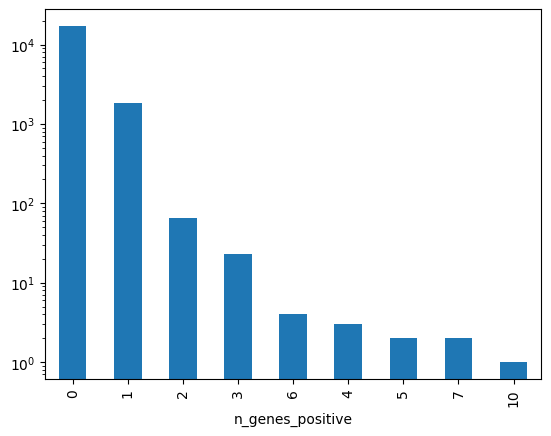

In [8]:
# create list of genes AND CORREPSONDET prots that are postive (from above)

# unzip in parallel pritens_clened and genes_clened and create ritens_clened_psotive and genes_clened_positive 
    # maintain if proteins comes form psotive gene
uniref_df["proteins_positive"], uniref_df["genes_positive"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if g in positive_genes], # protein is postive based on gene
        [g for g in row["gene"] if g in positive_genes]
    ),
    axis=1
))
uniref_df["n_genes_positive"] = uniref_df["genes_positive"].apply(len)
uniref_df.sort_values(by="n_genes_positive", ascending=False, inplace=True)

display(uniref_df.head(5))
display(uniref_df.shape)
uniref_df.n_genes_positive.value_counts().plot(kind="bar", logy=True)

## Give probs to positive genes

In [9]:
# give probablities to be samped to each protein
uniref_df["logits"] = uniref_df["genes_positive"].apply(
    lambda gene_list: [positive_gene_freq_map.get(g, 0) for g in gene_list]
)
def safe_softmax(logits):
    if len(logits) == 0:
        return []  # return empty list if no logits
    return softmax(logits).tolist()  # convert numpy array to list
uniref_df["probs"] = uniref_df["logits"].apply(safe_softmax)

uniref_df.head(2)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,logits,probs
13,UniRef50_P01563,"[P32881, P01566, P01571, P05015, P01568, P0501...","[IFNA8, IFNA10, IFNA17, IFNA16, IFNA21, IFNA4,...",10,10,"[P32881, P01566, P01571, P05015, P01568, P0501...","[IFNA8, IFNA10, IFNA17, IFNA16, IFNA21, IFNA4,...",positive,10,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
27,UniRef50_P0DN86,"[A6NKQ9, P0DN86, P0DN87, P0DN86, P0DN86, Q6NT5...","[CGB1, CGB8, CGB7, CGB5, CGB3, CGB2, LHB]",7,7,"[A6NKQ9, P0DN86, P0DN87, P0DN86, P0DN86, Q6NT5...","[CGB1, CGB8, CGB7, CGB5, CGB3, CGB2, LHB]",positive,7,"[1, 1, 1, 1, 1, 1, 1]","[0.14285714285714285, 0.14285714285714285, 0.1..."


# Mark NEGATIVE genes

Create a list for each cluster that contains genes that are negative. 

We will sample from this list later to create the negative class.

We define a negative gene as:

- they cant be positive genes
- they cant be ambiguos genes
- OPTIONAL: many proteins of same class but still differt (ex. odoranr receptros)
    - SOLUTION: solve wht pfam and interpro domains --> group proteins that have same domains --> take only one from the group

In [10]:
# All genes in uniref_df
putative_negative_genes = set().union(*uniref_df.gene)
print(len(putative_negative_genes))

# Remove positve and ambibuos
putative_negative_genes = putative_negative_genes.difference(positive_genes)
print(len(putative_negative_genes))
putative_negative_genes = putative_negative_genes.difference(ambiguos_genes)
print(len(putative_negative_genes))


20311
18186
18186


### Optional: Remove duplicated protein domains

In [11]:
# interpro_df = pd.read_csv(config["data_paths"]["interprot_domains"], sep="\t")

# def extract_ids(cell, prefix):
#     if pd.isna(cell):
#         return []
#     # Find all matches like PFxxxxx or IPRxxxxx
#     ids = re.findall(rf"{prefix}\d+", cell)
#     return list(set(ids))  # optional: remove duplicates

# # Apply parsing
# interpro_df["Pfam_list"] = interpro_df["Pfam"].apply(lambda x: extract_ids(str(x), "PF"))
# interpro_df["InterPro_list"] = interpro_df["InterPro"].apply(lambda x: extract_ids(str(x), "IPR"))

# interpro_df["n_Pfam"] = interpro_df["Pfam_list"].apply(len)
# interpro_df["n_InterPro"] = interpro_df["InterPro_list"].apply(len)

# interpro_df["all_domains"] = interpro_df.apply(lambda row: set(row['Pfam_list']) | set(row['InterPro_list']), axis=1)

# interpro_df

In [12]:
# # Filter to current subset of prots
# interpro_df = interpro_df[interpro_df.Entry.isin(putative_negative_protein_gene_df.protein.to_list())]

# # Convert sets to frozensets for grouping (sets aren't hashable)
# interpro_df['domains_hashable'] = interpro_df['all_domains'].apply(frozenset)

# # Group by domains and aggregate
# final_groups_df = (
#     interpro_df[interpro_df.duplicated(subset=['domains_hashable'], keep=False)] #keep=False, mark all pccurencies
#     .groupby('domains_hashable')['Entry']  # group by set of domains
#     .agg(Proteins_in_Group=list, Group_Size='size')
#         #Collect all the protein_id values in the group into a list
#         #'size'	Count how many items are in the group
#     .reset_index()
#     .sort_values('Group_Size', ascending=False)
# )

# # Convert frozensets back to sets for display
# final_groups_df['all_domains'] = final_groups_df['domains_hashable'].apply(set)
# final_groups_df = final_groups_df.drop(columns=['domains_hashable'])

# display(final_groups_df)

# # Clean up the temporary column
# interpro_df = interpro_df.drop(columns=['domains_hashable'])
# interpro_df = interpro_df.drop_duplicates(subset="all_domains")

# # Filter df
# putative_negative_protein_gene_df = putative_negative_protein_gene_df[putative_negative_protein_gene_df.protein.isin(interpro_df.Entry.to_list())]

# print("Remained proteins:", len(putative_negative_protein_gene_df))

### Optional: subsample to remove proteins with overlapping domains

In [13]:
# # Flatten the Jaccard matrix (exclude diagonal if it's 1.0 self-similarity)
# jaccard_values = jaccard_matrix[np.triu_indices_from(jaccard_matrix, k=1)]  # Upper triangle only
# jaccard_values = jaccard_values[jaccard_values != 0]

# # Create histogram
# plt.figure(figsize=(10, 6))
# plt.hist(jaccard_values, bins=100, edgecolor='black', alpha=0.7)
# plt.xlabel('Jaccard Similarity', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.title('Distribution of Jaccard Similarities', fontsize=14)
# plt.grid(axis='y', alpha=0.3)

# # Add statistics
# mean_val = np.mean(jaccard_values)
# median_val = np.median(jaccard_values)
# plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
# plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.3f}')
# plt.legend()

# # Print summary statistics
# print("Jaccard Similarity Statistics:")
# print(f"Min: {jaccard_values.min():.4f}")
# print(f"Max: {jaccard_values.max():.4f}")
# print(f"Mean: {mean_val:.4f}")
# print(f"Median: {median_val:.4f}")
# print(f"Std: {np.std(jaccard_values):.4f}")

In [14]:
# # Create edge list using SIMILARITY (Jaccard) as weights
# # Leiden with ModularityVertexPartition: higher weight = stronger connection
# threshold = median_val  # Minimum Jaccard similarity to create an edge

# edges = []
# weights = []
# for i in range(len(jaccard_df)):
#     for j in range(i+1, len(jaccard_df)):
#         similarity = jaccard_matrix[i, j]
#         if similarity > threshold:  # Use similarity directly
#             edges.append((i, j))
#             weights.append(similarity)  # Higher Jaccard = stronger edge

# # Create igraph
# g = ig.Graph(n=len(jaccard_df), edges=edges)
# g.es['weight'] = weights

# # Run Leiden clustering
# partition = leidenalg.find_partition(
#     g, 
#     leidenalg.ModularityVertexPartition,
#     weights='weight',
#     n_iterations=-1,  # Run until convergence
#     seed=42 
# )

# # Add cluster labels to dataframe
# interpro_df['Leiden_Cluster'] = partition.membership

# for i, g in interpro_df.groupby(['Leiden_Cluster']):
#     print("Cluster name", i, "Lenght:", len(g))
#     display("Memebers:", g.Entry.unique())
#     if i[0] == 0:
#         break

# print(f"\nNumber of clusters: {len(set(partition.membership))}")
# print(f"Modularity: {partition.modularity:.3f}")
# print(f"\nCluster sizes:")
# display(interpro_df['Leiden_Cluster'].value_counts().sort_index())

# # Check for singletons (clusters with only 1 member)
# cluster_sizes = interpro_df['Leiden_Cluster'].value_counts()
# singletons = cluster_sizes[cluster_sizes == 1]
# print(f"\nSingletons (clusters of size 1): {len(singletons)}")

In [15]:
# # retain onlyu one prot form each cluster
# interpro_df_filtered = interpro_df.drop_duplicates(subset=["Leiden_Cluster"]).copy()
# display(interpro_df_filtered)

# # Filter df
# putative_negative_protein_gene_df = putative_negative_protein_gene_df[putative_negative_protein_gene_df.protein.isin(interpro_df_filtered.Entry.to_list())]
# display(putative_negative_protein_gene_df)


## Prepare col where to sample negatives

In [16]:
# Create list of putative negative genes/protein        
    # ATTENTION; putatove = neither postive neither ambigous
uniref_df["putative_negative_proteins"], uniref_df["putative_negative_genes"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if g in putative_negative_genes],
        [g for p, g in zip(row["protein"], row["gene"]) if g in putative_negative_genes],
    ),
    axis=1
))
# count
uniref_df["n_putative_negative_genes"] = uniref_df.putative_negative_genes.apply(len)

# ATTENTION: same NEGATIVE clusters coudl have 0 proteins
# necause all proteins are postive OR ambigous so nothing left to sample as negative)

display(uniref_df.head(5))


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes
13,UniRef50_P01563,"[P32881, P01566, P01571, P05015, P01568, P0501...","[IFNA8, IFNA10, IFNA17, IFNA16, IFNA21, IFNA4,...",10,10,"[P32881, P01566, P01571, P05015, P01568, P0501...","[IFNA8, IFNA10, IFNA17, IFNA16, IFNA21, IFNA4,...",positive,10,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",[],[],0
27,UniRef50_P0DN86,"[A6NKQ9, P0DN86, P0DN87, P0DN86, P0DN86, Q6NT5...","[CGB1, CGB8, CGB7, CGB5, CGB3, CGB2, LHB]",7,7,"[A6NKQ9, P0DN86, P0DN87, P0DN86, P0DN86, Q6NT5...","[CGB1, CGB8, CGB7, CGB5, CGB3, CGB2, LHB]",positive,7,"[1, 1, 1, 1, 1, 1, 1]","[0.14285714285714285, 0.14285714285714285, 0.1...",[],[],0
30,UniRef50_P04430,"[A0A0B4J2D9, P0DP09, P04430, P01601, A0A0B4J1Z...","[IGKV1D-13, IGKV1-13, IGKV1-16, IGKV1D-16, IGK...",7,7,"[A0A0B4J2D9, P0DP09, P04430, P01601, A0A0B4J1Z...","[IGKV1D-13, IGKV1-13, IGKV1-16, IGKV1D-16, IGK...",positive,7,"[1, 1, 1, 1, 1, 1, 1]","[0.14285714285714285, 0.14285714285714285, 0.1...",[],[],0
36,UniRef50_P23083,"[P23083, A0A0C4DH31, A0A0C4DH33, P01743, A0A0J...","[IGHV1-2, IGHV1-18, IGHV1-24, IGHV1-46, IGHV5-...",6,6,"[P23083, A0A0C4DH31, A0A0C4DH33, P01743, A0A0J...","[IGHV1-2, IGHV1-18, IGHV1-24, IGHV1-46, IGHV5-...",positive,6,"[1, 1, 1, 1, 1, 1]","[0.16666666666666666, 0.16666666666666666, 0.1...",[],[],0
42,UniRef50_P01597,"[A0A087WSZ0, P01594, P01597, P01593, P04432, A...","[IGKV1D-8, IGKV1-33, IGKV1-39, IGKV1D-33, IGKV...",6,6,"[A0A087WSZ0, P01594, P01597, P01593, P04432, A...","[IGKV1D-8, IGKV1-33, IGKV1-39, IGKV1D-33, IGKV...",positive,6,"[1, 1, 1, 1, 1, 1]","[0.16666666666666666, 0.16666666666666666, 0.1...",[],[],0


# *) Are there enriched clusters?

fraction_positive
0.000000    17034
0.200000        1
0.250000        1
0.333333        4
0.400000        1
0.500000       13
1.000000     1935
Name: count, dtype: int64


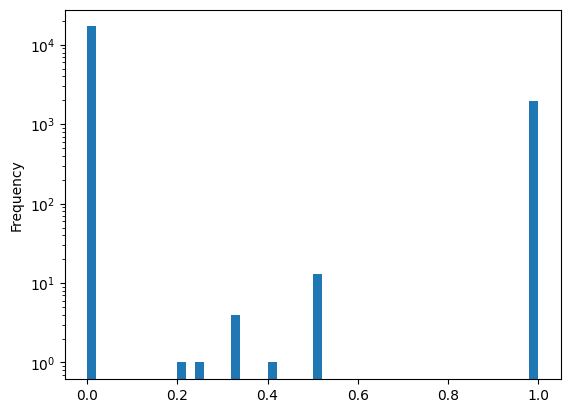

In [17]:
# FRACTION OF CLUSTER OCCUPIED BY POSITIVE GENES
uniref_df["fraction_positive"] = uniref_df.n_genes_positive / uniref_df.n_genes
uniref_df.sort_values(by="fraction_positive", inplace=True, ascending=False)

# hsit
uniref_df.fraction_positive.plot(kind="hist", logy=True, bins=50)
print(uniref_df.fraction_positive.value_counts().sort_index())


In [18]:
# HYPERGEMOETRIC TEST

# Filter genesets with enough genes
    # ATTENTION
    # CANNOT USE TOO SMALL DRAWING (n) --> test power comes from the changing probabilities over several draws, known as sampling without replacemen
uniref_df_big = uniref_df[uniref_df.n_genes >= 1].copy()

# Define background
total_genes = len(set().union(*uniref_df_big["gene"]))
total_positive = len(set().union(*uniref_df_big["genes_positive"]))
print(f"Unique total genes: {total_genes}")
print(f"Unique total positive genes: {total_positive}")

# Run enrichment test
results = uniref_df_big.apply(
    lambda row: pd.Series(
        dataf.per_cluster_hypergeom_test(
            row["n_genes"], 
            row["n_genes_positive"], 
            total_genes, 
            total_positive
        )
    ), 
    axis=1
)
results.columns = ["enrichment_prob", "enrichment_pvalue"]

# Combine results
df_uniref_enriched = pd.concat([uniref_df_big, results], axis=1)
df_uniref_enriched = df_uniref_enriched.sort_values("enrichment_pvalue")

# Multiple testing correction (FDR)
df_uniref_enriched["enrichment_pvalue_adj"] = multipletests(
    df_uniref_enriched["enrichment_pvalue"], 
    method="fdr_bh"
)[1]
df_uniref_enriched["significant"] = df_uniref_enriched["enrichment_pvalue_adj"] < 0.05

# Summary
print(f"\nSignificant enriched gene sets: {df_uniref_enriched['significant'].sum()} / {len(df_uniref_enriched)}")
display(
    df_uniref_enriched[
        ["UniRef50_Cluster", "n_genes", "n_genes_positive", 
         "enrichment_prob", "enrichment_pvalue", 
         "enrichment_pvalue_adj", "significant"]
    ].head(10)
)

# only enriched
df_uniref_significant = df_uniref_enriched[df_uniref_enriched['significant'] == True]

Unique total genes: 20311
Unique total positive genes: 2125

Significant enriched gene sets: 9 / 18989


,UniRef50_Cluster,n_genes,n_genes_positive,enrichment_prob,enrichment_pvalue,enrichment_pvalue_adj,significant
13,UniRef50_P01563,10,10,1.541800e-10,1.541800e-10,0.000003,True
30,UniRef50_P04430,7,7,1.360023e-07,1.360023e-07,0.000861,True
27,UniRef50_P0DN86,7,7,1.360023e-07,1.360023e-07,0.000861,True
36,UniRef50_P23083,6,6,1.303222e-06,1.303222e-06,0.003535,True
47,UniRef50_Q8IVG9,6,6,1.303222e-06,1.303222e-06,0.003535,True
42,UniRef50_P01597,6,6,1.303222e-06,1.303222e-06,0.003535,True
38,UniRef50_P10147,6,6,1.303222e-06,1.303222e-06,0.003535,True
61,UniRef50_P04746,5,5,1.248265e-05,1.248265e-05,0.026337,True
60,UniRef50_P01619,5,5,1.248265e-05,1.248265e-05,0.026337,True
105,UniRef50_A2NJV5,4,4,1.195121e-04,1.195121e-04,0.189118,False


# Create Dataset

## Positive class sampling

In [19]:
# Filter only positive clusters
uniref_df_pos = uniref_df[uniref_df.cluster_label == "positive"].copy()

# sample or take all postive proteins?
if not config["dataset_creation"]["sample_positive_genes"]:
    SAMPLE_N_POSITIVE = uniref_df_pos.n_genes_positive.max() # the number to sample is the max possbile
else:
    SAMPLE_N_POSITIVE = config["dataset_creation"]["number_positive_genes_to_sample_per_cluster"]

uniref_df_pos["proteins_sampled"], uniref_df_pos["genes_sampled"] = zip(
    *uniref_df_pos.apply(
            dataf.sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=SAMPLE_N_POSITIVE, 
            gene_col="genes_positive",  # ATTENTION_: sample from correct columns
            prot_col="proteins_positive", 
            probs_col="probs")
)
uniref_df_pos["n_proteins_sampled"] = uniref_df_pos.proteins_sampled.apply(len)

display(uniref_df_pos.head(2))
print(uniref_df_pos.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled
9602,UniRef50_Q9EQG7,[Q9UJA9],[ENPP5],1,1,[Q9UJA9],[ENPP5],positive,1,[1],[1.0],[],[],0,1.0,[Q9UJA9],[ENPP5],1
10138,UniRef50_P13284,[P13284],[IFI30],1,1,[P13284],[IFI30],positive,1,[1],[1.0],[],[],0,1.0,[P13284],[IFI30],1


(1955, 18)


## Negative Sampling

- do not use clusters that are negative but have 0 negative prots (ex all are ambiguos)
- do not take neagtive proteins that come form psotive lcusters (even if the single proteins are negative)
- sample proteins wiht uniform distr

In [20]:
# Filter only negative clusters
    # sample from clusters that do nto contain psotive (negative label of before)
uniref_df_neg = uniref_df[
    (uniref_df.n_putative_negative_genes > 0) & # some lcuster maybe haev only ambigus genes
    (uniref_df.cluster_label == "negative") # avoid proteins from proteins class are used as eagtive
    ].copy() 

# Sample or nor sample?
if config["dataset_creation"]["sample_negative_genes"]:
    print("Sampling negative class")
    
    uniref_df_neg["proteins_sampled"], uniref_df_neg["genes_sampled"] = zip(
        *uniref_df_neg.apply(
                dataf.sample_sampled_from_single_row, 
                axis=1, 
                min_sample_n=SAMPLE_N_POSITIVE, 
                gene_col="putative_negative_genes",  # ATTENTION
                prot_col="putative_negative_proteins", 
                probs_col=None # uniform
                )
    )
else:
    uniref_df_neg["proteins_sampled"], uniref_df_neg["genes_sampled"] = uniref_df_neg["putative_negative_proteins"], uniref_df_neg["putative_negative_genes"] 

uniref_df_neg["n_proteins_sampled"] = uniref_df_neg.proteins_sampled.apply(len)

# ATTENTION: same clusters coudl have 0 proteins to sample from (all proteins are postive OR ambigous so nothing left to sample as negative)
uniref_df_neg = uniref_df_neg[uniref_df_neg.n_proteins_sampled > 0]

display(uniref_df_neg.head())
print(uniref_df_neg.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled
2081,UniRef50_Q96BA8,[Q96BA8],[CREB3L1],1,1,[],[],negative,0,[],[],[Q96BA8],[CREB3L1],1,0.0,[Q96BA8],[CREB3L1],1
2083,UniRef50_Q96B96,[Q96B96],[LDAF1],1,1,[],[],negative,0,[],[],[Q96B96],[LDAF1],1,0.0,[Q96B96],[LDAF1],1
2084,UniRef50_Q92966,[Q92966],[SNAPC3],1,1,[],[],negative,0,[],[],[Q92966],[SNAPC3],1,0.0,[Q92966],[SNAPC3],1
2085,UniRef50_Q92930,[Q92930],[RAB8B],1,1,[],[],negative,0,[],[],[Q92930],[RAB8B],1,0.0,[Q92930],[RAB8B],1
2086,UniRef50_Q92830,[Q92830],[KAT2A],1,1,[],[],negative,0,[],[],[Q92830],[KAT2A],1,0.0,[Q92830],[KAT2A],1


(17034, 18)


## Make dataset

- concat pos and neg
- expand to have

| Cluster | protein name | label | seq |

In [21]:
# add labels
uniref_df_pos["label_single_prot"] = 1
uniref_df_neg["label_single_prot"] = 0

# merge --> each entry is a cluster
dataset_df = pd.concat([uniref_df_pos, uniref_df_neg])
display(dataset_df.head())
display(dataset_df.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled,label_single_prot
9602,UniRef50_Q9EQG7,[Q9UJA9],[ENPP5],1,1,[Q9UJA9],[ENPP5],positive,1,[1],[1.0],[],[],0,1.0,[Q9UJA9],[ENPP5],1,1
10138,UniRef50_P13284,[P13284],[IFI30],1,1,[P13284],[IFI30],positive,1,[1],[1.0],[],[],0,1.0,[P13284],[IFI30],1,1
10140,UniRef50_P13232,[P13232],[IL7],1,1,[P13232],[IL7],positive,1,[1],[1.0],[],[],0,1.0,[P13232],[IL7],1,1
10148,UniRef50_P12961,[P05408],[SCG5],1,1,[P05408],[SCG5],positive,1,[1],[1.0],[],[],0,1.0,[P05408],[SCG5],1,1
9583,UniRef50_Q9GZZ8,[Q9GZZ8],[LACRT],1,1,[Q9GZZ8],[LACRT],positive,1,[1],[1.0],[],[],0,1.0,[Q9GZZ8],[LACRT],1,1


(18989, 19)

In [22]:
# Create long df

# smaller df
cols_to_keep = ['UniRef50_Cluster', 'proteins_sampled',
                'genes_sampled', 'label_single_prot']
dataset_df_small = dataset_df[cols_to_keep].copy()

# Create a new DataFrame where each row corresponds to a (protein, gene) pair
rows = []
for _, row in dataset_df_small.iterrows():
    cluster = row["UniRef50_Cluster"]
    label = row["label_single_prot"]
    proteins = row["proteins_sampled"]
    genes = row["genes_sampled"]

    # zip ensures 1-to-1 pairing between proteins and genes
    for prot, gene in zip(proteins, genes):
        rows.append({
            "UniRef50_Cluster": cluster,
            "protein": prot,
            "gene": gene,
            "label": label
        })

df_long = pd.DataFrame(rows)

print("ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins")
print(df_long.protein.nunique(), "/ ~20000")

# checj fro duplcates
print("\nDuplicated rows/proteins: ", df_long.shape[0] - df_long.protein.nunique())

df_long

ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins
20153 / ~20000

Duplicated rows/proteins:  127


,UniRef50_Cluster,protein,gene,label
0,UniRef50_Q9EQG7,Q9UJA9,ENPP5,1
1,UniRef50_P13284,P13284,IFI30,1
2,UniRef50_P13232,P13232,IL7,1
3,UniRef50_P12961,P05408,SCG5,1
4,UniRef50_Q9GZZ8,Q9GZZ8,LACRT,1
...,...,...,...,...
20275,UniRef50_P51788,P51788,CLCN2,0
20276,UniRef50_Q5T4I8,Q5T4I8,C6orf52,0
20277,UniRef50_Q5T0J3,Q5T0J3,C1orf220,0
20278,UniRef50_Q5T0J7,Q5T0J7,TEX35,0


## Assure 1:N ratio in postive:negative class
After previos sampling sampling you will have
- | pos prot | << | neg prot | → more thna 1:3 ration
- Need to subsampled negative class
- Subsample negative class
    - Subsample the remaining cluster to have a final ratio 1:3

In [23]:
if config["dataset_creation"]["sample_negative_genes"]:
    print("Sampling")
    
    # list of smpled positve proteins
    positive_proteins_tmp = set(df_long[df_long.label == 1]["protein"].unique())

    # list of prtein in MIXED cluster (wiht inside btoh postive and negative prteins)
        # ATTENTUON: check no ptortien in mixed clusters
    proteins_in_mixed_clusters = df_long.groupby('UniRef50_Cluster').filter(lambda x: x['label'].nunique() > 1).sort_values(by="UniRef50_Cluster")
    print("priteins in mixed clusters:", len(proteins_in_mixed_clusters))
    proteins_in_mixed_clusters = set(proteins_in_mixed_clusters["protein"].unique())

    # proteins to NOT remove
    proteins_not_to_remove = proteins_in_mixed_clusters.union(positive_proteins_tmp)

    # give col
    df_long["can_be_removed"] = ~df_long["protein"].isin(proteins_not_to_remove)


    # decide fraction to susample

    # Number of positive proteins
    n_positive = df_long[df_long["label"] == 1].shape[0]
    # Number desidered negative
    n_desired_negatives = n_positive * config["dataset_creation"]["mult_factor_negative_class"]
    # Removable (negative) proteins
    removable_negatives = df_long[(df_long["label"] == 0) & (df_long["can_be_removed"])]
    # Determine fraction to subsample
    frac_to_sample = n_desired_negatives / len(removable_negatives)
    frac_to_sample = min(frac_to_sample, 1.0)  # cannot sample more than available

    frac_to_sample


    # susample
    removable = df_long[df_long["can_be_removed"]]
    keep = df_long[~df_long["can_be_removed"]]

    subsampled_removable = removable.sample(frac=frac_to_sample)

    df_subsampled = pd.concat([keep, subsampled_removable]).reset_index(drop=True) # Combine back with the protected proteins

else:
    df_subsampled = df_long.copy()

print(df_subsampled.label.value_counts())
df_subsampled

label
0    18155
1     2125
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,label
0,UniRef50_Q9EQG7,Q9UJA9,ENPP5,1
1,UniRef50_P13284,P13284,IFI30,1
2,UniRef50_P13232,P13232,IL7,1
3,UniRef50_P12961,P05408,SCG5,1
4,UniRef50_Q9GZZ8,Q9GZZ8,LACRT,1
...,...,...,...,...
20275,UniRef50_P51788,P51788,CLCN2,0
20276,UniRef50_Q5T4I8,Q5T4I8,C6orf52,0
20277,UniRef50_Q5T0J3,Q5T0J3,C1orf220,0
20278,UniRef50_Q5T0J7,Q5T0J7,TEX35,0


## Give Sequence


In [24]:
### create df to join
join_df_tmp = proteome_uniprot[["Entry", "Sequence"]].copy().rename(columns={"Sequence": "sequence"})

# join
    # ATTNETION: we shoudl NOT lose any col
long_df_seq = pd.merge(how="inner", left=df_subsampled, right=join_df_tmp, left_on="protein", right_on="Entry")

# drp cols
long_df_seq.drop(columns=["Entry"], inplace=True)

long_df_seq

,UniRef50_Cluster,protein,gene,label,sequence
0,UniRef50_Q9EQG7,Q9UJA9,ENPP5,1,MTSKFLLVSFILAALSLSTTFSLQPDQQKVLLVSFDGFRWDYLYKV...
1,UniRef50_P13284,P13284,IFI30,1,MTLSPLLLFLPPLLLLLDVPTAAVQASPLQALDFFGNGPPVNYKTG...
2,UniRef50_P13232,P13232,IL7,1,MFHVSFRYIFGLPPLILVLLPVASSDCDIEGKDGKQYESVLMVSID...
3,UniRef50_P12961,P05408,SCG5,1,MVSRMVSTMLSGLLFWLASGWTPAFAYSPRTPDRVSEADIQRLLHG...
4,UniRef50_Q9GZZ8,Q9GZZ8,LACRT,1,MKFTTLLFLAAVAGALVYAEDASSDSTGADPAQEAGTSKPNEEISG...
...,...,...,...,...,...
20275,UniRef50_P51788,P51788,CLCN2,0,MAAAAAEEGMEPRALQYEQTLMYGRYTQDLGAFAKEEAARIRLGGP...
20276,UniRef50_Q5T4I8,Q5T4I8,C6orf52,0,MAQPESSADFGIAQQNNYYCYWQSLPSAIRVKQEFQPSQSYRYGNW...
20277,UniRef50_Q5T0J3,Q5T0J3,C1orf220,0,MIPVRGLWYCYLQVKKVRLREAERLGPKSQCPAECGAASWISWVLQ...
20278,UniRef50_Q5T0J7,Q5T0J7,TEX35,0,MSAKRAELKKTHLSKNYKAVCLELKPEPTKTFDYKAVKQEGRFTKA...


## Stratify dataset

We can stratify based on many metrics:
1. labels
2. PREVALENT metric
3. **based on cluster**
    - Put proteins coming from same cluster in different sets or not

In [25]:
from sklearn.model_selection import train_test_split
import pandas as pd

# --- group-level stratified split ---

# pslit by cluster and then ive back set-label to each row

# One representative row per UniRef50_Cluster
cluster_df = long_df_seq.groupby('UniRef50_Cluster').first().reset_index()

# Stratified split by label, but at the cluster level
    # ists of unique cluster IDs.
train_clusters, temp_clusters = train_test_split(
    cluster_df['UniRef50_Cluster'],
    test_size=0.2,
    stratify=cluster_df['label'],
    random_state=42
)

# Split the temporary set equally into validation and test
temp_labels = cluster_df.loc[cluster_df['UniRef50_Cluster'].isin(temp_clusters), 'label']
val_clusters, test_clusters = train_test_split(
    temp_clusters,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

# --- assign back to the full dataframe ---
#Every row in long_df_seq inherits its set label based on its UniRef50_Cluster
long_df_seq['set'] = ''
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(train_clusters), 'set'] = 'train'
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(test_clusters), 'set'] = 'test'

# ATTENTION: ingore val
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(val_clusters), 'set'] = 'val'
long_df_seq.loc[long_df_seq['set'] == "val", 'set'] = 'test'
long_df_seq.loc[long_df_seq.loc[long_df_seq['set'] == 'test'].index[0], 'set'] = 'val' 

# Check split distribution
print(long_df_seq.groupby('set')['label'].value_counts().unstack(fill_value=0))
display(long_df_seq)


label      0     1
set               
test    3641   423
train  14514  1701
val        0     1


,UniRef50_Cluster,protein,gene,label,sequence,set
0,UniRef50_Q9EQG7,Q9UJA9,ENPP5,1,MTSKFLLVSFILAALSLSTTFSLQPDQQKVLLVSFDGFRWDYLYKV...,val
1,UniRef50_P13284,P13284,IFI30,1,MTLSPLLLFLPPLLLLLDVPTAAVQASPLQALDFFGNGPPVNYKTG...,train
2,UniRef50_P13232,P13232,IL7,1,MFHVSFRYIFGLPPLILVLLPVASSDCDIEGKDGKQYESVLMVSID...,train
3,UniRef50_P12961,P05408,SCG5,1,MVSRMVSTMLSGLLFWLASGWTPAFAYSPRTPDRVSEADIQRLLHG...,train
4,UniRef50_Q9GZZ8,Q9GZZ8,LACRT,1,MKFTTLLFLAAVAGALVYAEDASSDSTGADPAQEAGTSKPNEEISG...,train
...,...,...,...,...,...,...
20275,UniRef50_P51788,P51788,CLCN2,0,MAAAAAEEGMEPRALQYEQTLMYGRYTQDLGAFAKEEAARIRLGGP...,train
20276,UniRef50_Q5T4I8,Q5T4I8,C6orf52,0,MAQPESSADFGIAQQNNYYCYWQSLPSAIRVKQEFQPSQSYRYGNW...,train
20277,UniRef50_Q5T0J3,Q5T0J3,C1orf220,0,MIPVRGLWYCYLQVKKVRLREAERLGPKSQCPAECGAASWISWVLQ...,train
20278,UniRef50_Q5T0J7,Q5T0J7,TEX35,0,MSAKRAELKKTHLSKNYKAVCLELKPEPTKTFDYKAVKQEGRFTKA...,train


In [26]:
# CHECK: if i have nto sampled pos class, i shodul have used all pos genes
genes_not_used = set(positive_genes_df.gene).difference(long_df_seq.gene)
print(genes_not_used)
uniref_df[uniref_df.gene.apply(lambda x: len(set(x).intersection(genes_not_used)) != 0)]


{'IGHD1-1'}


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,proteins_positive,genes_positive,cluster_label,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive


# Save

In [27]:
save_path = os.path.join(
    os.path.dirname(positive_genes_path),
    f"{dataset_name}_03_dataset_final_sample-neg={config['dataset_creation']['sample_negative_genes']}.csv"
)
long_df_seq.to_csv(save_path, index=False)

print(save_path)

/home/gdallagl/myworkdir/ESMSec/data/cell_location/secreted_Uniprot-locations_03_dataset_final_sample-neg=False.csv
